In [34]:
def drop_tweets_before_cleaning_table(db_name='Twitter_Final_DB.db'):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    # SQL query to drop the Tweets_before_cleaning
    drop_table_query = '''
    DROP TABLE IF EXISTS cleaned_tweets;
    '''

    cursor.execute(drop_table_query)
    connection.commit()
    connection.close()

    print("Tweets_before_cleaning Table deleted from Twitter_Final_DB.")

# Call the function to delete the Tweets_before_cleaning
drop_tweets_before_cleaning_table()

Tweets_before_cleaning Table deleted from Twitter_Final_DB.


In [35]:
def drop_Users_before_cleaning_table(db_name='Twitter_Final_DB.db'):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    # SQL query to drop the Users_before_cleaning
    drop_table_query = '''
    DROP TABLE IF EXISTS cleaned_users;
    '''

    cursor.execute(drop_table_query)
    connection.commit()
    connection.close()

    print("Users_before_cleaning Table deleted from Twitter_Final_DB.")

# Call the function to delete the Users_before_cleaning
drop_Users_before_cleaning_table()

Users_before_cleaning Table deleted from Twitter_Final_DB.


In [36]:
import sqlite3
import os
import json

# Path to the directory containing JSON files
data_dir = r"C:\Users\20232015\Downloads\data\data"

def create_database_schema(db_name='Twitter_database_v3.db'):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    table_creation_queries = [
        '''
        CREATE TABLE IF NOT EXISTS cleaned_tweets (
            created_at TEXT,
            id_str TEXT PRIMARY KEY,
            text TEXT,
            source TEXT,
            in_reply_to_status_id_str TEXT,
            in_reply_to_user_id_str TEXT,
            in_reply_to_screen_name TEXT,
            user TEXT,
            place TEXT,
            is_quote_status BOOLEAN,
            quote_count INTEGER,
            reply_count INTEGER,
            retweet_count INTEGER,
            favorite_count INTEGER,
            favorited BOOLEAN,
            retweeted BOOLEAN,
            lang TEXT,
            quoted_status_id_str TEXT,
            quoted_status_created_at TEXT,
            quoted_status_text TEXT
        )
        ''',
        '''
        CREATE TABLE IF NOT EXISTS cleaned_users (
            id_str TEXT PRIMARY KEY,
            name TEXT,
            screen_name TEXT,
            location TEXT,
            url TEXT,
            description TEXT,
            protected BOOLEAN,
            verified BOOLEAN,
            followers_count INTEGER,
            friends_count INTEGER,
            listed_count INTEGER,
            favourites_count INTEGER,
            statuses_count INTEGER,
            created_at TEXT,
            geo_enabled BOOLEAN,
            contributors_enabled BOOLEAN,
            is_translator BOOLEAN
        )
        '''
    ]

    for query in table_creation_queries:
        cursor.execute(query)

    connection.commit() 
    connection.close()

    print("Database schema updated successfully.")

def populate_database_from_json(db_name='Twitter_database_v3.db', data_dir=data_dir):
    print(f"Data directory path: {data_dir}")

    if not os.path.exists(data_dir):
        print(f"Data directory does not exist: {data_dir}")
        return

    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()
    
    for filename in os.listdir(data_dir):
        if filename.endswith('.json'):
            file_path = os.path.join(data_dir, filename)
            print(f"Processing file: {file_path}")
    
            with open(file_path, 'r', encoding='utf-8') as file:
                for line in file:
                    try:
                        data = json.loads(line)
                    except json.JSONDecodeError as e:
                        print(f"Error decoding JSON from file {filename}: {e}")
                        continue
    
                    if 'created_at' in data and 'id_str' in data and ('text' in data or 'full_text' in data):
                        quoted_status_id_str = None
                        quoted_status_created_at = None
                        quoted_status_text = None
    
                        if data.get('is_quote_status') and 'quoted_status' in data:
                            quoted_status_id_str = data['quoted_status'].get('id_str')
                            quoted_status_created_at = data['quoted_status'].get('created_at')
                            quoted_status_text = data['quoted_status'].get('text') if data['quoted_status'].get('full_text') is None else data['quoted_status'].get('full_text')
    
                        cursor.execute('''
                        INSERT OR IGNORE INTO cleaned_tweets (
                            created_at, id_str, text, source, in_reply_to_status_id_str, 
                            in_reply_to_user_id_str, in_reply_to_screen_name, user, place, is_quote_status, 
                            quote_count, reply_count, retweet_count, favorite_count, favorited, retweeted, 
                            lang, quoted_status_id_str, quoted_status_created_at, quoted_status_text
                        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                        ''', (
                            data.get('created_at'), data.get('id_str'),
                            data.get('text') if data.get('full_text') is None else data.get('full_text'),
                            data.get('source'), data.get('in_reply_to_status_id_str'),
                            data.get('in_reply_to_user_id_str'), data.get('in_reply_to_screen_name'), json.dumps(data.get('user')),
                            json.dumps(data.get('place')), data.get('is_quote_status'), data.get('quote_count'), data.get('reply_count'), data.get('retweet_count'), data.get('favorite_count'),
                            data.get('favorited'), data.get('retweeted'), data.get('lang'),
                            quoted_status_id_str, quoted_status_created_at, quoted_status_text
                        ))

                        user = data.get('user')
                        if user:
                            cursor.execute('''
                            INSERT OR IGNORE INTO cleaned_users (
                                id_str, name, screen_name, location, url, description, protected, 
                                verified, followers_count, friends_count, listed_count, favourites_count, 
                                statuses_count, created_at, geo_enabled, contributors_enabled, is_translator
                            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                            ''', (
                                user.get('id_str'), user.get('name'), user.get('screen_name'), user.get('location'),
                                user.get('url'), user.get('description'), user.get('protected'), user.get('verified'),
                                user.get('followers_count'), user.get('friends_count'), user.get('listed_count'), user.get('favourites_count'),
                                user.get('statuses_count'), user.get('created_at'), user.get('geo_enabled'), 
                                user.get('contributors_enabled'), user.get('is_translator')
                            ))

    connection.commit()
    connection.close()

    print("Database populated successfully from JSON files.")

    # Print the absolute path of the database file
    db_path = os.path.abspath(db_name)
    print(f"Database file path: {db_path}")



In [37]:
create_database_schema(db_name='Twitter_database_v3.db')

Database schema updated successfully.


In [38]:
populate_database_from_json()

Data directory path: C:\Users\20232015\Downloads\data\data
Processing file: C:\Users\20232015\Downloads\data\data\airlines-1558527599826.json
Processing file: C:\Users\20232015\Downloads\data\data\airlines-1558546003827.json
Processing file: C:\Users\20232015\Downloads\data\data\airlines-1558611772040.json
Error decoding JSON from file airlines-1558611772040.json: Expecting value: line 1 column 1 (char 0)
Error decoding JSON from file airlines-1558611772040.json: Expecting value: line 1 column 1 (char 0)
Error decoding JSON from file airlines-1558611772040.json: Expecting value: line 1 column 1 (char 0)
Error decoding JSON from file airlines-1558611772040.json: Expecting value: line 1 column 1 (char 0)
Error decoding JSON from file airlines-1558611772040.json: Expecting value: line 1 column 1 (char 0)
Error decoding JSON from file airlines-1558611772040.json: Expecting value: line 1 column 1 (char 0)
Error decoding JSON from file airlines-1558611772040.json: Expecting value: line 1 col

In [ ]:
populate_database_from_json(data_dir=data_dir)

In [ ]:
def create_conversations_table(db_name='Twitter_database_v3.db'):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    conversations_table_query = [
        '''
    CREATE TABLE IF NOT EXISTS conversations_table AS
SELECT
    created_at,
    id_str,
    text,
    in_reply_to_status_id_str,
    in_reply_to_user_id_str,
    in_reply_to_screen_name,
    user,
    1 AS is_quote_status,
    json_extract(extended_tweet, '$.full_text') AS extended_tweet_full_text,
    quote_count,
    reply_count,
    favorite_count,
    retweet_count,
    lang,
    (SELECT text FROM Tweets_before_cleaning WHERE id_str = t.in_reply_to_status_id_str) AS original_tweet_text
    FROM
    (SELECT * FROM Tweets_before_cleaning WHERE is_quote_status = 1 LIMIT 100) AS t;
            
        '''
   ]
    
    cursor.execute(conversations_table_query)
    connection.commit()
    connection.close()

    print("Conversations Table added to Twitter_Final_DB. Database has been Updated.")

In [39]:
import sqlite3

# Path to the database
db_name = 'Twitter_database_v3.db'

# Connect to the SQLite database
connection = sqlite3.connect(db_name)
cursor = connection.cursor()

# SQL query to create the new table with Virgin Atlantic related tweets
create_table_query = '''
CREATE TABLE IF NOT EXISTS virgin_atlantic_tweets AS
SELECT *
FROM cleaned_tweets
WHERE text LIKE '%Virgin Atlantic%' OR text LIKE '%@VirginAtlantic%' 
OR json_extract(user, '$.screen_name') = 'VirginAtlantic';
'''

# Execute the query
cursor.execute(create_table_query)

# Commit the changes and close the connection
connection.commit()
connection.close()

print("Table 'virgin_atlantic_tweets' created successfully with relevant tweets.")


Table 'virgin_atlantic_tweets' created successfully with relevant tweets.


In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

db_path = 'Twitter_database_v3.db'
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM virgin_atlantic_tweets", conn)
conn.close()

true_count = df['is_quote_status'].sum()
false_count = len(df) - true_count
counts = {'True_Count': true_count, 'False_Count': false_count}

labels = ['True', 'False']
sizes = [counts['True_Count'], counts['False_Count']]
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title(f'Percentage of tweets which are quote tweets')
plt.axis('equal')

In [44]:
import sqlite3

def create_conversations_table(db_name='Twitter_database_v3.db'):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    conversations_table_query = '''
    CREATE TABLE IF NOT EXISTS conversations_table AS
    SELECT
        t.created_at,
        t.id_str,
        t.text,
        t.in_reply_to_status_id_str,
        t.in_reply_to_user_id_str,
        t.in_reply_to_screen_name,
        t.user,
        t.is_quote_status,
        t.quote_count,
        t.reply_count,
        t.favorite_count,
        t.retweet_count,
        t.lang,
        t.quoted_status_id_str,
        t.quoted_status_created_at,
        t.quoted_status_text,
        (SELECT text FROM cleaned_tweets WHERE id_str = t.in_reply_to_status_id_str) AS original_tweet_text
    FROM
        cleaned_tweets AS t
    WHERE
        t.is_quote_status IS NOT "0" OR t.in_reply_to_status_id_str IS NOT NULL
    '''

    cursor.execute(conversations_table_query)
    connection.commit()
    connection.close()

    print("Conversations Table added to the database. Database has been updated.")

create_conversations_table()

Conversations Table added to the database. Database has been updated.


In [51]:
def drop_influencer_tweets_table(db_name='Twitter_database_v3.db'):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    # SQL query to drop the Tweets_before_cleaning
    drop_table_query = '''
    DROP TABLE IF EXISTS influencer_tweets;
    '''

    cursor.execute(drop_table_query)
    connection.commit()
    connection.close()

    print("influencer tweets Table deleted from Twitter_Final_DB.")

# Call the function to delete the Tweets_before_cleaning
drop_influencer_tweets_table()

influencer tweets Table deleted from Twitter_Final_DB.


In [52]:
import sqlite3

def create_influencer_tweets_table(db_name='Twitter_database_v3.db'):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    influencer_tweets_query = '''
    CREATE TABLE IF NOT EXISTS influencer_tweets AS
    SELECT *
    FROM virgin_atlantic_tweets
    WHERE json_extract(user, '$.verified') = 1
    AND json_extract(user, '$.followers_count') > 25000
    AND json_extract(user, '$.screen_name') != 'VirginAtlantic';
    '''

    cursor.execute(influencer_tweets_query)
    connection.commit()
    connection.close()

    print("Influencer Tweets Table created successfully.")

# Call the function to create the influencer_tweets table
create_influencer_tweets_table()


Influencer Tweets Table created successfully.


Response Times Table created successfully.
Average response time to influencers: nan minutes
Average response time to normal users: nan minutes


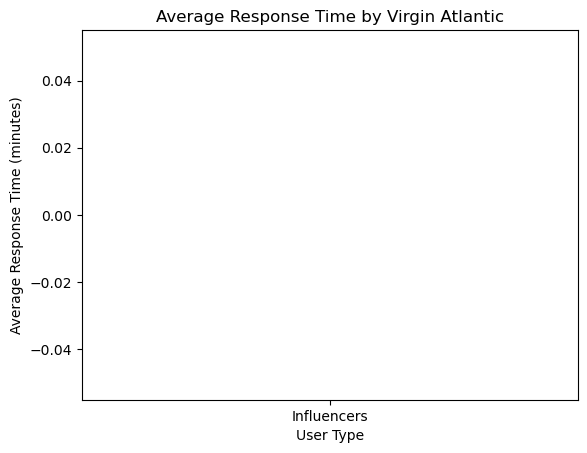

In [54]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

def create_response_times_table(db_name='Twitter_database_v3.db'):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    # Create the response_times table from conversations_table
    response_times_query = '''
    CREATE TABLE IF NOT EXISTS response_times AS
    SELECT
        t1.id_str AS reply_id,
        t1.created_at AS reply_created_at,
        t2.id_str AS original_tweet_id,
        t2.created_at AS original_tweet_created_at,
        t2.user AS original_tweet_user,
        (julianday(t1.created_at) - julianday(t2.created_at)) * 24 * 60 AS response_time_minutes
    FROM
        conversations_table AS t1
    JOIN
        conversations_table AS t2
    ON
        t1.in_reply_to_status_id_str = t2.id_str
    WHERE
        json_extract(t1.user, '$.screen_name') = 'VirginAtlantic';
    '''
    
    cursor.execute(response_times_query)
    connection.commit()
    connection.close()

    print("Response Times Table created successfully.")

def calculate_and_plot_average_response_times(db_name='Twitter_database_v3.db'):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    # Query the response times
    query = '''
    SELECT
        original_tweet_user,
        response_time_minutes,
        json_extract(original_tweet_user, '$.verified') AS is_verified,
        json_extract(original_tweet_user, '$.followers_count') AS followers_count
    FROM
        response_times
    '''
    
    df = pd.read_sql_query(query, connection)
    connection.close()

    # Define influencers as verified users with more than 25k followers
    df['is_influencer'] = df.apply(lambda row: row['is_verified'] == 1 and row['followers_count'] > 25000, axis=1)

    # Calculate average response times
    average_response_time_influencers = df[df['is_influencer']]['response_time_minutes'].mean()
    average_response_time_normal_users = df[~df['is_influencer']]['response_time_minutes'].mean()

    # Print the average response times
    print(f"Average response time to influencers: {average_response_time_influencers} minutes")
    print(f"Average response time to normal users: {average_response_time_normal_users} minutes")

    # Plot the average response times
    categories = ['Influencers', 'Normal Users']
    average_times = [average_response_time_influencers, average_response_time_normal_users]

    plt.bar(categories, average_times, color=['blue', 'green'])
    plt.xlabel('User Type')
    plt.ylabel('Average Response Time (minutes)')
    plt.title('Average Response Time by Virgin Atlantic')
    plt.show()

# Create the response_times table from conversations_table
create_response_times_table()

# Calculate, print, and plot the average response times
calculate_and_plot_average_response_times()


In [56]:
def drop_response_table(db_name='Twitter_database_v3.db'):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    # SQL query to drop the Tweets_before_cleaning
    drop_table_query = '''
    DROP TABLE response_times
    '''

    cursor.execute(drop_table_query)
    connection.commit()
    connection.close()

    print("influencer tweets Table deleted from Twitter_Final_DB.")

# Call the function to delete the Tweets_before_cleaning
drop_response_table()

influencer tweets Table deleted from Twitter_Final_DB.


In [1]:
import pandas as pd
import sqlite3
import time
import matplotlib as plt

def process_replies_and_quotes(db_name='twitter_database_v3.db', table_name='conversations_table'):
    start_time = time.time()

    conn = sqlite3.connect(db_name)

    # Load data from the specified table into a pandas DataFrame
    print(f"Loading data from {table_name}...")
    conversations_query = f"""
    SELECT 
        created_at, 
        id_str, 
        in_reply_to_status_id_str,
        json_extract(user, '$.id_str') AS user_id_str,
        quoted_status_created_at
    FROM 
        {table_name}
    """
    conversations_df = pd.read_sql_query(conversations_query, conn)

    # Load data from cleaned_tweets into a pandas DataFrame
    print("Loading data from cleaned_tweets...")
    cleaned_tweets_query = """
    SELECT 
        created_at AS in_reply_to_created_at,
        id_str
    FROM 
        cleaned_tweets
    """
    cleaned_tweets_df = pd.read_sql_query(cleaned_tweets_query, conn)

    # Close the database connection
    conn.close()

    # Convert to datetime
    conversations_df['created_at'] = pd.to_datetime(conversations_df['created_at'])
    conversations_df['quoted_status_created_at'] = pd.to_datetime(conversations_df['quoted_status_created_at'])
    cleaned_tweets_df['in_reply_to_created_at'] = pd.to_datetime(cleaned_tweets_df['in_reply_to_created_at'])

    # Merge the dataframes to add in_reply_to_created_at column
    merged_df = conversations_df.merge(cleaned_tweets_df, left_on='in_reply_to_status_id_str', right_on='id_str', how='left', suffixes=('', '_reply'))

    # Calculate the time differences
    merged_df['time_diff_quoted'] = (merged_df['created_at'] - merged_df['quoted_status_created_at']).dt.total_seconds()
    merged_df['time_diff_reply'] = (merged_df['created_at'] - merged_df['in_reply_to_created_at']).dt.total_seconds()

    # Filter the time differences to be outside -1 to +1 seconds
    time_diff_quoted_filtered = merged_df[(merged_df['time_diff_quoted'] <= -1) | (merged_df['time_diff_quoted'] >= 1)]
    time_diff_reply_filtered = merged_df[(merged_df['time_diff_reply'] <= -1) | (merged_df['time_diff_reply'] >= 1)]

    # Create dictionaries for time differences
    time_diff_quoted_dict = time_diff_quoted_filtered.set_index('id_str')['time_diff_quoted'].to_dict()
    time_diff_reply_dict = time_diff_reply_filtered.set_index('id_str')['time_diff_reply'].to_dict()

    end_time = time.time()
    print(f"Total time taken to run for {table_name}: {end_time - start_time} seconds\n")

    return time_diff_quoted_dict, time_diff_reply_dict

# Call the function for each table
time_diff_quoted_dict_conversations, time_diff_reply_dict_conversations = process_replies_and_quotes(table_name='conversations_table')
time_diff_quoted_dict_influencers, time_diff_reply_dict_influencers = process_replies_and_quotes(table_name='influencer_tweets')
time_diff_quoted_dict_virgin, time_diff_reply_dict_virgin = process_replies_and_quotes(table_name='virgin_atlantic_tweets')

# Function to print the first key-value pair of a dictionary
def print_first_kv_pair(dictionary, dict_name):
    if dictionary:
        first_key = next(iter(dictionary))
        print(f"First key-value pair of {dict_name}: {first_key}: {dictionary[first_key]}")
    else:
        print(f"{dict_name} is empty.")

# Print the first key-value pair of each dictionary
print_first_kv_pair(time_diff_quoted_dict_conversations, 'Quoted Status Time Differences (Conversations)')
print_first_kv_pair(time_diff_reply_dict_conversations, 'Reply Status Time Differences (Conversations)')
print_first_kv_pair(time_diff_quoted_dict_influencers, 'Quoted Status Time Differences (Influencers)')
print_first_kv_pair(time_diff_reply_dict_influencers, 'Reply Status Time Differences (Influencers)')
print_first_kv_pair(time_diff_quoted_dict_virgin, 'Quoted Status Time Differences (Virgin Atlantic)')
print_first_kv_pair(time_diff_reply_dict_virgin, 'Reply Status Time Differences (Virgin Atlantic)')

def plot_time_differences(time_diff_dict, title, filename):
    # Convert the time differences from timedelta to seconds
    time_diff_seconds = list(time_diff_dict.values())

    # Plot histogram for time differences
    plt.figure(figsize=(10, 6))
    plt.hist(time_diff_seconds, bins=50, color='blue', alpha=0.7)
    plt.xlabel('Time Difference (seconds)')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

# Plot and save histograms for each dictionary
plot_time_differences(time_diff_quoted_dict_conversations, 'Time Difference for Quoted Status (Conversations)', 'time_diff_quoted_conversations.png')
plot_time_differences(time_diff_reply_dict_conversations, 'Time Difference for Reply Status (Conversations)', 'time_diff_reply_conversations.png')
plot_time_differences(time_diff_quoted_dict_influencers, 'Time Difference for Quoted Status (Influencers)', 'time_diff_quoted_influencers.png')
plot_time_differences(time_diff_reply_dict_influencers, 'Time Difference for Reply Status (Influencers)', 'time_diff_reply_influencers.png')
plot_time_differences(time_diff_quoted_dict_virgin, 'Time Difference for Quoted Status (Virgin Atlantic)', 'time_diff_quoted_virgin.png')
plot_time_differences(time_diff_reply_dict_virgin, 'Time Difference for Reply Status (Virgin Atlantic)', 'time_diff_reply_virgin.png')

# Calculate and print the averages
def calculate_and_print_average(time_diff_dict, dict_name):
    if time_diff_dict:
        average = sum(time_diff_dict.values()) / len(time_diff_dict)
        print(f"Average time difference for {dict_name}: {average} seconds")
    else:
        print(f"{dict_name} is empty.")

calculate_and_print_average(time_diff_quoted_dict_conversations, 'Quoted Status Time Differences (Conversations)')
calculate_and_print_average(time_diff_reply_dict_conversations, 'Reply Status Time Differences (Conversations)')
calculate_and_print_average(time_diff_quoted_dict_influencers, 'Quoted Status Time Differences (Influencers)')
calculate_and_print_average(time_diff_reply_dict_influencers, 'Reply Status Time Differences (Influencers)')
calculate_and_print_average(time_diff_quoted_dict_virgin, 'Quoted Status Time Differences (Virgin Atlantic)')
calculate_and_print_average(time_diff_reply_dict_virgin, 'Reply Status Time Differences (Virgin Atlantic)')

print("Graphs have been generated and saved as PNG files, and averages have been calculated.")

Loading data from conversations_table...
Loading data from cleaned_tweets...


KeyboardInterrupt: 

In [ ]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect('Twitter_database_v3.db')

# Query to get a distinct list of airlines
query_airlines = """
SELECT DISTINCT airline
FROM cleaned_tweets
"""

# Execute the query and fetch the results
airlines = pd.read_sql(query_airlines, conn)
print(airlines)

# Close the database connection
conn.close()

In [ ]:
import sqlite3

# List of airline Twitter handles (excluding VirginAtlantic)
airline_handles = [
    'KLM', 'AirFrance', 'British_Airways', 'AmericanAir', 'Lufthansa', 
    'AirBerlin', 'AirBerlin_assist', 'easyJet', 'RyanAir', 'SingaporeAir', 
    'Qantas', 'EtihadAirways'
]

# Connect to the database
conn = sqlite3.connect('Twitter_database_v3.db')
cursor = conn.cursor()

# Query to count tweets per airline based on text content
query = """
SELECT user, COUNT(*) as tweet_count
FROM cleaned_tweets
WHERE {}
GROUP BY user
ORDER BY tweet_count ASC
LIMIT 2;
"""

# Generate the WHERE clause
where_clause = ' OR '.join(["text LIKE ?" for _ in airline_handles])
query = query.format(where_clause)

# Create the list of parameters for the query
params = [f'%{handle}%' for handle in airline_handles]

# Execute the query and fetch the results
cursor.execute(query, params)
result = cursor.fetchall()

# Close the database connection
conn.close()

# Display the results
print(result)

In [ ]:
import sqlite3
import json

# List of airline Twitter handles (excluding VirginAtlantic)
airline_handles = [
    'KLM', 'AirFrance', 'British_Airways', 'AmericanAir', 'Lufthansa', 
    'AirBerlin', 'AirBerlin_assist', 'easyJet', 'RyanAir', 'SingaporeAir', 
    'Qantas', 'EtihadAirways'
]

# Connect to the database
conn = sqlite3.connect('Twitter_database_v3.db')
cursor = conn.cursor()

# Retrieve all user data
query = "SELECT user FROM cleaned_tweets"
cursor.execute(query)
user_data = cursor.fetchall()

# Parse the user data and count tweets per airline
airline_tweet_count = {handle: 0 for handle in airline_handles}

for row in user_data:
    user_json = json.loads(row[0])
    screen_name = user_json.get('screen_name')
    if screen_name in airline_handles:
        airline_tweet_count[screen_name] += 1

# Sort the airlines by tweet count and get the two with the least tweets
sorted_airlines = sorted(airline_tweet_count.items(), key=lambda x: x[1])
least_tweet_airlines = [sorted_airlines[0][0], sorted_airlines[1][0]]

# Display the results
print(least_tweet_airlines)
print(airline_tweet_count)

In [ ]:
# Connect to the database
conn = sqlite3.connect('Twitter_database_v3.db')
cursor = conn.cursor()

# Create tables for each airline with the least tweets
for airline in ['SingaporeAir', 'Qantas']:
    create_table_query = f"""
    CREATE TABLE IF NOT EXISTS {airline}_tweets AS
    SELECT * FROM cleaned_tweets
    WHERE JSON_EXTRACT(user, '$.screen_name') = ?;
    """
    cursor.execute(create_table_query, (airline,))

# Commit the changes and close the connection
conn.commit()
conn.close()

In [ ]:
import sqlite3

# Connect to the database
conn = sqlite3.connect('Twitter_database_v3.db')
cursor = conn.cursor()

# List all tables to verify new tables were created
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
cursor.execute(tables_query)
tables = cursor.fetchall()
print("Tables in the database:", tables)

# Define the names of the newly created tables
least_tweet_airlines = ['SingaporeAir', 'Qantas']  # Replace with actual airline names from previous results
new_tables = [f"{airline}_tweets" for airline in least_tweet_airlines]

# Verify the new tables and summarize the number of tweets in each
for table in new_tables:
    if (table,) in tables:
        count_query = f"SELECT COUNT(*) FROM {table};"
        cursor.execute(count_query)
        tweet_count = cursor.fetchone()[0]
        print(f"Table '{table}' exists with {tweet_count} tweets.")
    else:
        print(f"Table '{table}' does not exist.")

# Close the database connection
conn.close()

In [ ]:
import sqlite3

# Connect to the database
conn = sqlite3.connect('Twitter_database_v3.db')
cursor = conn.cursor()

# Define the names of the tables to be removed
tables_to_remove = ['AirFrance_tweets', 'Lufthansa_tweets']

# Drop the tables
for table in tables_to_remove:
    drop_table_query = f"DROP TABLE IF EXISTS {table};"
    cursor.execute(drop_table_query)

# Commit the changes
conn.commit()

# Verify that the tables have been deleted
verify_query = "SELECT name FROM sqlite_master WHERE type='table';"
cursor.execute(verify_query)
remaining_tables = cursor.fetchall()
print("Remaining tables in the database:", remaining_tables)

# Close the database connection
conn.close()

In [ ]:
import sqlite3

# Connect to the database
conn = sqlite3.connect('Twitter_database_v3.db')
cursor = conn.cursor()

# Define the names of the tables to be verified
tables_to_verify = ['SingaporeAir_tweets', 'Qantas_tweets']

# Verify that the tables exist and summarize their contents
for table in tables_to_verify:
    # Check if the table exists
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name=?;", (table,))
    table_exists = cursor.fetchone()
    
    if table_exists:
        # Get the count of tweets in the table
        count_query = f"SELECT COUNT(*) FROM {table};"
        cursor.execute(count_query)
        tweet_count = cursor.fetchone()[0]
        print(f"Table '{table}' exists and has {tweet_count} tweets.")
        
        # Optionally, fetch and display the first few rows for a quick check
        fetch_query = f"SELECT * FROM {table} LIMIT 5;"
        cursor.execute(fetch_query)
        rows = cursor.fetchall()
        print(f"First few rows in '{table}':")
        for row in rows:
            print(row)
    else:
        print(f"Table '{table}' does not exist.")

# Close the database connection
conn.close()